# Определение стоимости автомобилей

Сервис по продаже автомобилей с пробегом разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. В вашем распоряжении исторические данные: технические характеристики, комплектации и цены автомобилей. Вам нужно построить модель для определения стоимости. 

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

**ПЛАН**

1. Подготовка данных

  1.1 Обзор данных

  1.2 Обработка признаков

  1.3 Кодирование категориальных признаков
  

2. Обучение моделей

  2.1 Линейная регрессия

  2.2 RandomForestRegressor

  2.3 Градиентный бустинг LightGBM

  2.4 Градиентный бустинг CatBoost


3. Анализ результатов

## Подготовка данных

In [1]:
! pip install category_encoders

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import warnings
warnings.filterwarnings('ignore')


from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from category_encoders import TargetEncoder

from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor

Defaulting to user installation because normal site-packages is not writeable


In [2]:
try:
    cars = pd.read_csv('C:/ya_pr/autos/autos.csv')
except:
    cars = pd.read_csv('/datasets/autos.csv')
    

### Обзор данных

Посмотрим на общую информацию о датасете:

In [3]:
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
cars.head(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06


In [5]:
cars.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [6]:
cars.duplicated().sum()

4

Дубликатов почти нет. 

In [7]:
num_features = ['Price','Power','Kilometer','RegistrationYear','RegistrationMonth']

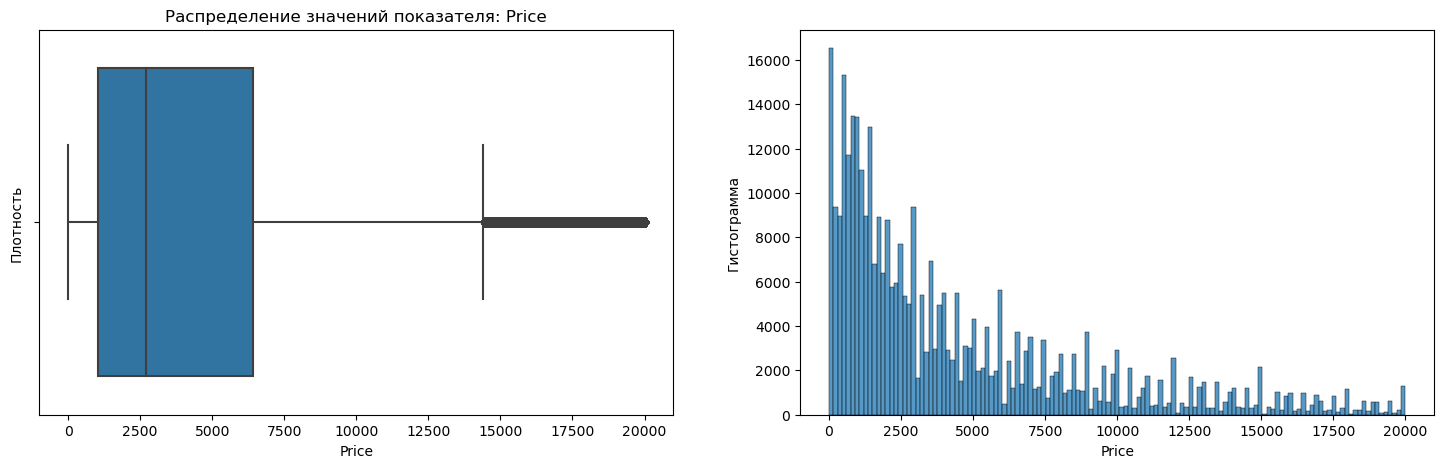

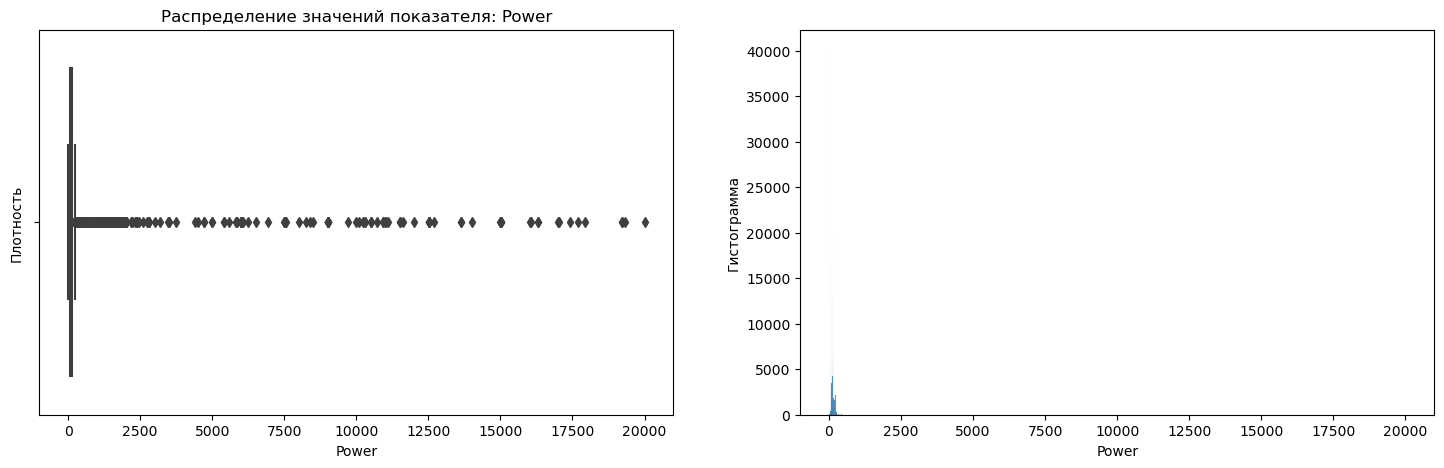

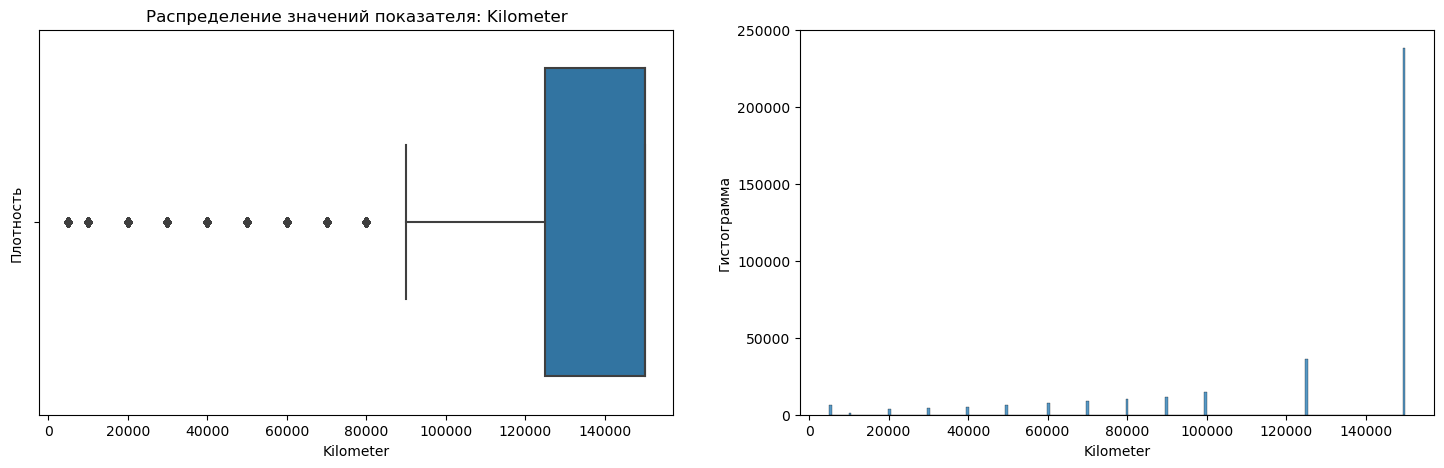

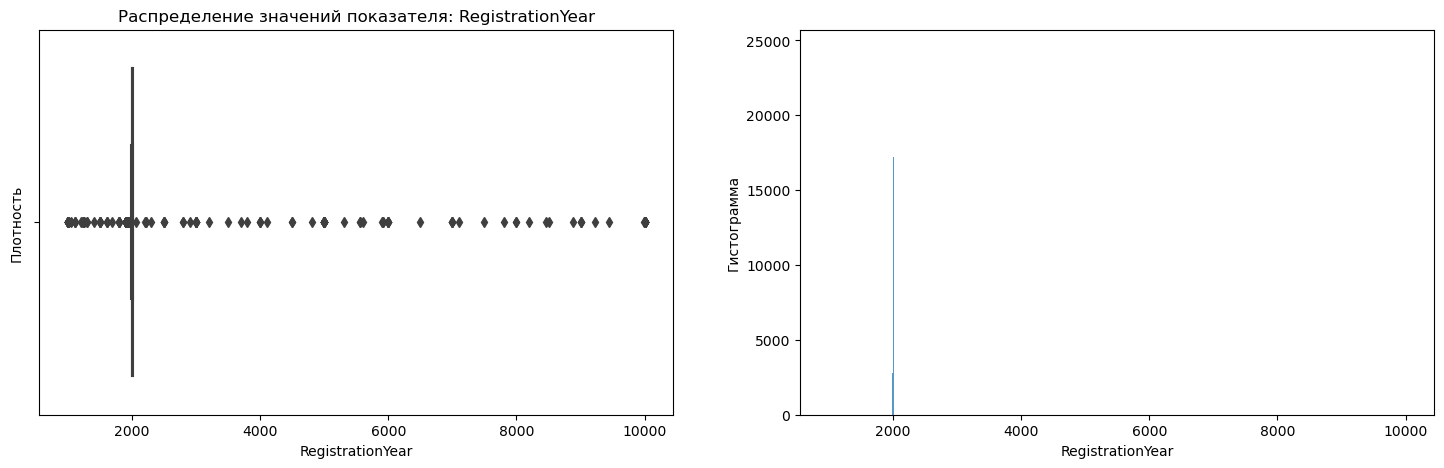

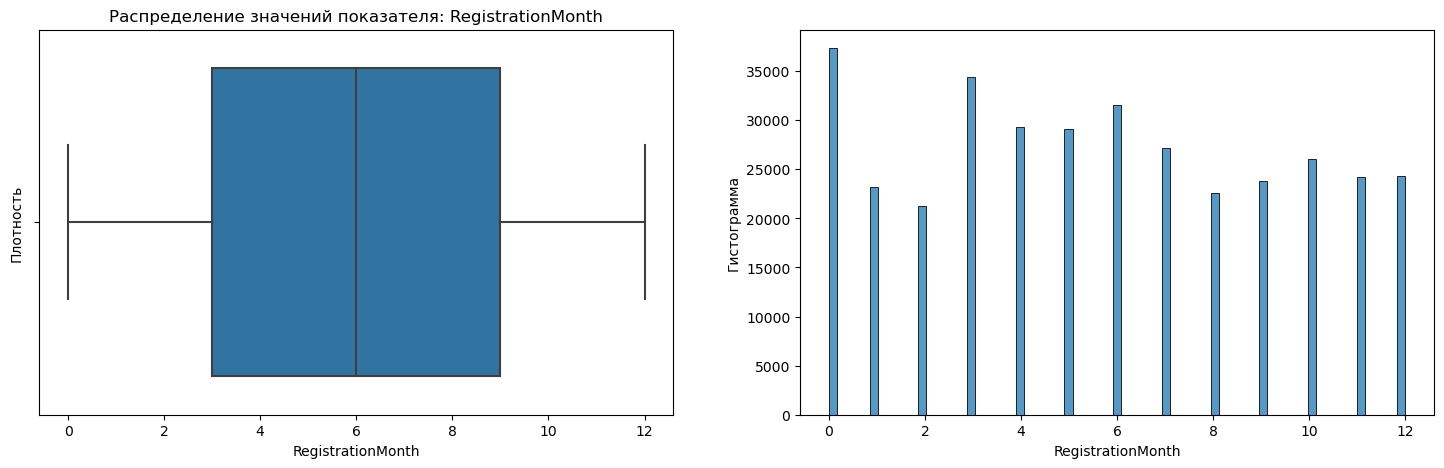

In [8]:
for col in num_features:
    fig,axes = plt.subplots(1, 2, figsize=(18,5))
    axes[0].set_title('Распределение значений показателя: ' + col)
    axes[0].set(xlabel=col, ylabel='Плотность')
    axes[1].set(xlabel=col, ylabel='Гистограмма')
    sns.boxplot(cars[col],ax=axes[0])
    sns.histplot(cars[col],ax=axes[1])
    plt.show()

### Обработка признаков

**DateCrawled, DateCreated, LastSeen** - в датасете есть три даты - полезная информация (год и сезон, когда был продан автомобиль) - одна и та же.

переведем в формат дат. 
Вероятно столбцы DateCrawled, DateCreated дублируют друг друга с точностью до дня (время скачивания анкеты не имеет никакого значения).

In [9]:
cars['DateCrawled'] = pd.to_datetime(cars['DateCrawled']).dt.date
cars['DateCreated'] = pd.to_datetime(cars['DateCreated']).dt.date
cars['LastSeen'] = pd.to_datetime(cars['LastSeen']).dt.date

In [10]:
(cars['DateCrawled'] - cars['DateCreated']).value_counts().head(20)

0 days     342585
1 days      10273
2 days        543
3 days         85
4 days         80
6 days         77
5 days         72
7 days         65
8 days         45
15 days        41
9 days         28
10 days        28
13 days        25
14 days        22
11 days        22
12 days        21
18 days        20
16 days        18
20 days        17
19 days        16
dtype: int64

Для 97% записей даты DateCreated и DateCrawled не отличаются, а для 99% разница составляет не более 2 дней. Удалим столбец DateCrawled (отметим, что предположительно дата скачивания анкеты вообще не должна влиять на цену):

In [11]:
cars = cars.drop('DateCrawled',axis=1)

Рассмотрм оставшуюся дату LastSeen - дата последней активности пользователя:

In [12]:
print('Самая ранняя дата последнего просмотра:',cars['LastSeen'].min())
print('Самая поздняя дата последнего просмотра:',cars['LastSeen'].max())
print()
print('Самая ранняя дата создания анкеты:',cars['DateCreated'].min())
print('Самая поздняя дата создания анкеты:',cars['DateCreated'].max())

Самая ранняя дата последнего просмотра: 2016-03-05
Самая поздняя дата последнего просмотра: 2016-04-07

Самая ранняя дата создания анкеты: 2014-03-10
Самая поздняя дата создания анкеты: 2016-04-07


Все даты последнего просмотра близки к максимальной дате создания анкеты, а максимальная дата последнего просмотра равна максимальной дате создания анкеты - видимо даты последнего просмотра не связаны с фактом продажи машины (скорее все анкеты регулярно просматриваются и даты последнего просмотра связаны с датой выгрузки данных). 

Следовательно эта дата не имеет значения для стоимости машины. Удалим этот столбец: 

In [13]:
cars = cars.drop('LastSeen',axis=1)

In [14]:
cars['days_created'] = (cars['DateCreated'] - cars['DateCreated'].min()).dt.days

In [15]:
cars = cars.drop('DateCreated',axis=1)

**Price** — цена (евро):

In [16]:
print('Кол-во объявлений с нулевой ценой:',cars.loc[cars['Price'] == 0]['Price'].count())

Кол-во объявлений с нулевой ценой: 10772


Вероятно это пропуски данных. Мы не можем восстановить эти данные. Удалим эти строки:

In [17]:
cars = cars.loc[cars['Price'] != 0]

**Model** и **VehicleType, Gearbox, FuelType, Power** - название модели и признаки характеризующие модель:

In [18]:
print('Кол-во объявлений, в которых не указана модель:',cars.loc[cars['Model'].isna()]['Price'].count())

Кол-во объявлений, в которых не указана модель: 17521


Модель машины - один из важнейших признаков определяющих цену машины. Мы не можем восстановить эти пропуски. Удалим соответствующие строки:

In [19]:
cars = cars.loc[~cars['Model'].isna()]

In [20]:
print('Кол-во объявлений, в которых не указан тип:',cars.loc[cars['VehicleType'].isna()]['Price'].count())
print('Кол-во объявлений, в которых не указан тип коробки передач:',cars.loc[cars['Gearbox'].isna()]['Price'].count())
print('Кол-во объявлений, в которых не указан тип топлива:',cars.loc[cars['FuelType'].isna()]['Price'].count())
print('Кол-во объявлений, в которых не указана мощность:',cars.loc[cars['Power'].isna()]['Price'].count())

Кол-во объявлений, в которых не указан тип: 28166
Кол-во объявлений, в которых не указан тип коробки передач: 14270
Кол-во объявлений, в которых не указан тип топлива: 23551
Кол-во объявлений, в которых не указана мощность: 0


Пропуски составляют значительную часть данных, проверим можем ли мы заполнить их наиболее частыми значениями для каждой модели (т.к. мы рассматриваем именно характеристики моделей):

In [21]:
cars['Model'].value_counts().head(10)

golf        28246
other       23707
3er         19179
polo        12628
corsa       12197
astra       10475
passat       9835
a4           9642
c_klasse     8174
5er          7665
Name: Model, dtype: int64

Для other такой подход не возможен (это не одна модель а группа моделей). Проверим для наиболее часто встречающейся - "golf":

In [22]:
cars.loc[cars['Model']=='golf'].groupby('Model')['VehicleType'].value_counts()

Model  VehicleType
golf   sedan          14467
       small           3724
       wagon           3132
       convertible     1900
       bus              759
       coupe            412
       other            172
       suv               24
Name: VehicleType, dtype: int64

In [23]:
cars.loc[cars['Model']=='golf'].groupby('Model')['Gearbox'].value_counts()

Model  Gearbox
golf   manual     24002
       auto        2927
Name: Gearbox, dtype: int64

In [24]:
cars.loc[cars['Model']=='golf'].groupby('Model')['FuelType'].value_counts()

Model  FuelType
golf   petrol      18869
       gasoline     6987
       lpg           168
       cng            23
       other           7
       electric        3
       hybrid          1
Name: FuelType, dtype: int64

Есть преобладающие значения, но и других значений так же много. Все три признака значительно влияют на цену машины, ошибчное присвоение внесет значительную погрешность - такой путь не подходит. Заполним пропуски значениями "other" (в признаках уже есть такие значения, по смыслу это тоже самое что пропуски):

In [25]:
cars['VehicleType'] = cars['VehicleType'].fillna('other')
cars['Gearbox'] = cars['Gearbox'].fillna('other')
cars['FuelType'] = cars['FuelType'].fillna('other')

Power - мощность (л. с.)

In [26]:
cars.loc[cars['Power'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,NumberOfPictures,PostalCode,days_created


In [27]:
cars.loc[cars['Power']==0]['Price'].count()

31333

 - пропуски данных.

In [28]:
cars['Power'].quantile(q=0.999)

584.9250000000466

 - аномальные значения. 
 
 
 Заполним пропуски и аномальные значения медианными значениями для соответствующих моделей:

In [29]:
cars.loc[(cars['Power']==0) | (cars['Power'] > 600), 'Power'] = None
cars['Power'] = cars['Power'].fillna(cars.groupby('Model')['Power'].transform('median'))

In [30]:
cars.loc[cars['Power'].isna()]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,NumberOfPictures,PostalCode,days_created
234296,3800,wagon,1978,manual,NaN,serie_1,30000,0,gasoline,land_rover,NaN,0,49824,751


- с такой моделью только одна запись.

In [31]:
cars = cars.drop(cars.loc[cars['Power'].isna()].index)

**RegistrationYear** - год регистрации

В обзоре данных мы видели, что некоторые значения этого признака заведомо ошибочные (например год регистрации - 1000 или 9999):

In [32]:
print(cars['RegistrationYear'].quantile(0.001))

1962.074


Ранее (на основании исследования дат просмотра анкет и дат создания объявлений) мы убедились, что представленные данные не позднее 2016.04.07, т.е. год регистрации позже 2016 - ошибка:

In [33]:
len(cars.loc[cars['RegistrationYear']>2016])

11920

Примерно 3% всех данных. Это много:

In [34]:
len(cars.loc[cars['RegistrationYear']==2017])

8591

Большая часть "ошибок" приходится на 2017 год. Тогда мы можем предположить, что этот год не является ошибочным. 

Удалим все строки, где год регистрации позже 2017 или не позже 1962:

In [35]:
cars = cars.drop(cars.loc[(cars['RegistrationYear'] <= 1962) | (cars['RegistrationYear'] > 2017)].index)

**Repaired** - была машина в ремонте или нет.

Заполним пропуски значениями "undefined":

In [36]:
cars['Repaired'] = cars['Repaired'].fillna('undefined')

**NumberOfPictures** - количество фотографий - заполнен нулями, информция отсутствует. 

**PostalCode** - почтовый индекс - бесполезная информация. 

Удалим оба признака:

In [37]:
cars = cars.drop(['NumberOfPictures','PostalCode'], axis=1)

### Кодирование категориальных признаков

Не все модели поддерживают автоматическую обработку категориальных признаков. Создадим train и test выборки, в которых для кодирования категориальных признаков применим технику Target Encoding

In [38]:
train, test = train_test_split(cars, test_size=0.2, random_state=123)
train, valid = train_test_split(train, test_size=0.25, random_state=123)

In [39]:
categorial_columns = ['Model','VehicleType','Gearbox','FuelType','Brand','Repaired']

target_encoder = TargetEncoder()
train[categorial_columns] = target_encoder.fit_transform(train[categorial_columns],train['Price'])
valid[categorial_columns] = target_encoder.transform(valid[categorial_columns])
test[categorial_columns] = target_encoder.transform(test[categorial_columns])

X_train = train.drop('Price', axis=1)
y_train = train['Price']

X_valid = valid.drop('Price', axis=1)
y_valid = valid['Price']

## Обучение моделей

Функция тестирования моделей (производит обучение, прогноз, получает время затраченное на каждое из двух действий, вычисляет RMSE):

In [40]:
def test_model(model,features_train, features_test, target_train, target_test):
    
    fit_start_time = time.time()
    model.fit(features_train, target_train)
    fit_end_time = time.time()
    
    predict_start_time = time.time()
    predict = model.predict(features_test)
    predict_end_time = time.time()
    
    print('Время на обучение:', fit_end_time - fit_start_time)
    print('Время на прогноз:', predict_end_time - predict_start_time)
    print('RMSE на валидационной выборке:', mean_squared_error(target_test, predict)**0.5)


### Линейная регрессия

In [41]:
model = LinearRegression()
test_model(model, X_train, X_valid, y_train, y_valid)

Время на обучение: 0.16609501838684082
Время на прогноз: 0.013993024826049805
RMSE на валидационной выборке: 2794.6793727673903


### Случайный лес деревьев

In [42]:
for depth in range(5,16,5):
    model = RandomForestRegressor(n_estimators=60, max_depth=depth, n_jobs=4)
    print('max_depth=',depth)
    test_model(model, X_train, X_valid, y_train, y_valid)
    print('')

max_depth= 5
Время на обучение: 5.064787864685059
Время на прогноз: 0.05008077621459961
RMSE на валидационной выборке: 2325.9908028557566

max_depth= 10
Время на обучение: 7.817051649093628
Время на прогноз: 0.10039138793945312
RMSE на валидационной выборке: 1819.872432803465

max_depth= 15
Время на обучение: 10.848705291748047
Время на прогноз: 0.1832277774810791
RMSE на валидационной выборке: 1630.3798622502084



### Градиентный бустинг LightGBM

In [43]:
learning_rates = [0.01, 0.02, 0.05, 0.1, 0.2, 0.3]
for rate in learning_rates:
    model = LGBMRegressor(max_depth=50,learning_rate=rate, n_jobs=4)
    test_model(model, X_train, X_valid, y_train, y_valid)
    print('learning_rate=',rate)
    print('')

Время на обучение: 0.9834432601928711
Время на прогноз: 0.11635041236877441
RMSE на валидационной выборке: 2633.773331817184
learning_rate= 0.01

Время на обучение: 1.0502591133117676
Время на прогноз: 0.09957385063171387
RMSE на валидационной выборке: 2057.7704914590367
learning_rate= 0.02

Время на обучение: 1.049307107925415
Время на прогноз: 0.1173563003540039
RMSE на валидационной выборке: 1763.1648709131289
learning_rate= 0.05

Время на обучение: 0.8672056198120117
Время на прогноз: 0.13259458541870117
RMSE на валидационной выборке: 1698.9317144860704
learning_rate= 0.1

Время на обучение: 0.8842430114746094
Время на прогноз: 0.09934759140014648
RMSE на валидационной выборке: 1656.5594028542148
learning_rate= 0.2

Время на обучение: 0.6837253570556641
Время на прогноз: 0.09951639175415039
RMSE на валидационной выборке: 1648.3778787319368
learning_rate= 0.3



### Градиентный бустинг CatBoost

In [44]:
learning_rates = [0.01, 0.02, 0.05, 0.1, 0.2]
for rate in learning_rates:
    model = CatBoostRegressor(verbose=False, learning_rate=rate)
    test_model(model, X_train, X_valid, y_train, y_valid)
    print('learning_rate=',rate)
    print('')

Время на обучение: 18.800060987472534
Время на прогноз: 0.03296613693237305
RMSE на валидационной выборке: 1786.6868607186607
learning_rate= 0.01

Время на обучение: 18.421530723571777
Время на прогноз: 0.031249046325683594
RMSE на валидационной выборке: 1717.2592499755547
learning_rate= 0.02

Время на обучение: 18.012248754501343
Время на прогноз: 0.03271770477294922
RMSE на валидационной выборке: 1653.2029888082286
learning_rate= 0.05

Время на обучение: 18.89856743812561
Время на прогноз: 0.034026145935058594
RMSE на валидационной выборке: 1617.7489768275746
learning_rate= 0.1

Время на обучение: 18.08646035194397
Время на прогноз: 0.025433778762817383
RMSE на валидационной выборке: 1592.3486442506667
learning_rate= 0.2



## Анализ моделей

Посмотрим на результаты лучших моделей каждого типа:

In [45]:
models = pd.DataFrame({'Модель':['Линейная регрессия','RandomForest','LightGBM','CatBoost']
                       ,'Время на обучение':[0.07, 42.8, 2.56, 29.0]
                       ,'Время на прогноз':[0.01, 0.79, 0.32, 0.71]
                       ,'RMSE':[2793.65, 1628.51, 1649.56, 1595.29]})

In [46]:
models.head()

,Модель,Время на обучение,Время на прогноз,RMSE
0,Линейная регрессия,0.07,0.01,2793.65
1,RandomForest,42.80,0.79,1628.51
2,LightGBM,2.56,0.32,1649.56
3,CatBoost,29.00,0.71,1595.29


Самый точный прогноз делает (в соответствии с метрикой RMSE) модель градиентный бустинг CatBoost. RMSE = 1592.3. 
При этом время обучения этой модели большое, чем LightGBM. 

LightGBM - качество прогноза немного хуже (RMSE = 1652.6), однако многократно меньше время обучения модели (4 с против 26 c у CatBoost)

Линейная регрессия - самая быстрая (время на обучение - 0.07 с, время на прогноз -0.09 c), но качество её прогнозов существенно хуже чем у остальных моделей. RMSE = 2792. 

Проверим лучшую модель на тестовой выборке:

In [47]:
model = CatBoostRegressor(verbose=False, learning_rate=0.2)
test_model(model, X_train, X_valid, y_train, y_valid)

X_test = test.drop('Price', axis=1)
y_test = test['Price']

predict = model.predict(X_test)

print('RMSE на тестовой выборке:', mean_squared_error(y_test, predict)**0.5)

Время на обучение: 18.181769847869873
Время на прогноз: 0.016629457473754883
RMSE на валидационной выборке: 1592.3486442506667
RMSE на тестовой выборке: 1564.3679983581167
